In [1]:
from PIL import Image

In [2]:
import numpy as np 
import os
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import cv2

C:\Users\Nahian\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
from osgeo import gdal
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def unet_1(pretrained_weights = None, input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = merge([drop4,up6], mode = 'concat', concat_axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = merge([conv3,up7], mode = 'concat', concat_axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = merge([conv2,up8], mode = 'concat', concat_axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = merge([conv1,up9], mode = 'concat', concat_axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'softmax')(conv9)

    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model

In [5]:
def unet_2(input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    
    model.compile(optimizer=Adam(lr=1e-5), loss= 'binary_crossentropy', metrics= ['accuracy'])

    return model

In [6]:
model = unet_2()

In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [6]:
train_imageDir = "train\\slope"

In [7]:
train_labelDir = "train\\road"

In [8]:
test_imageDir = "test\\slope"

In [9]:
def images_to_array(imageDir):
    image_list = os.listdir(imageDir)
    arrayList = []
    for ind, image_name in enumerate(image_list):
        img_path = os.path.join(imageDir,image_name)

        img = cv2.imread(img_path, 0)
        resized_img = cv2.resize(img, (256, 256))
        
        resized_img = np.reshape(resized_img, resized_img.shape + (1,))
        
        arrayList.append(resized_img)
    
    arrayList = np.array(arrayList)
    return arrayList

In [10]:
def preprocess_slope_data(image):
    for row in range(image.shape[0]):
        for col in range(image.shape[1]):
            if image[row][col] < 0:
                image[row][col] = 0
            
    max_n = np.max(image)
    min_n = np.min(image)
    newImage = (image - min_n)/(max_n - min_n)
    newImage = newImage*255
    return newImage

In [11]:
def load_slope_data(directory):
    image_list = os.listdir(directory)
    arrayList = []
    for ind, image_name in enumerate(image_list):
        img_path = os.path.join(directory,image_name)

        ds = gdal.Open(img_path)
        img = ds.ReadAsArray()
        preprocessed_img = preprocess_slope_data(img)
        preprocessed_img = cv2.resize(preprocessed_img, (256, 256))
        
        resized_img = np.reshape(preprocessed_img, preprocessed_img.shape + (1,))
        
        arrayList.append(resized_img)
    
    arrayList = np.array(arrayList)
    return arrayList

In [12]:
def load_label(directory):
    image_list = os.listdir(directory)
    arrayList = []
    for ind, image_name in enumerate(image_list):
        img_path = os.path.join(directory,image_name)

        ds = gdal.Open(img_path)
        img = ds.ReadAsArray()
        img = cv2.resize(img, (256, 256))
        ## preprocess
        for row in range(img.shape[0]):
            for col in range(img.shape[1]):
                if img[row][col] > 0:
                    img[row][col] = 1
        print(img.shape)
        resized_img = np.reshape(img, img.shape + (1,))
        
        arrayList.append(resized_img)
    
    arrayList = np.array(arrayList)
    return arrayList

In [13]:
train_x = load_slope_data(train_imageDir)

In [14]:
train_y = load_label(train_labelDir)

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)


In [15]:
train_x.shape

(40, 256, 256, 1)

In [16]:
train_y.shape

(40, 256, 256, 1)

In [17]:
train_x

array([[[[ 20.632715 ],
         [ 47.795853 ],
         [ 34.9216   ],
         ...,
         [ 39.968227 ],
         [ 38.11967  ],
         [ 17.520088 ]],

        [[ 38.195637 ],
         [113.45643  ],
         [ 76.32608  ],
         ...,
         [ 76.80623  ],
         [ 77.127075 ],
         [ 36.217484 ]],

        [[ 24.926582 ],
         [ 94.18673  ],
         [ 83.520134 ],
         ...,
         [ 65.079475 ],
         [ 73.491974 ],
         [ 34.30561  ]],

        ...,

        [[ 46.872234 ],
         [ 95.1554   ],
         [ 72.17886  ],
         ...,
         [103.827644 ],
         [104.907776 ],
         [ 55.958046 ]],

        [[ 48.724953 ],
         [ 95.29018  ],
         [ 93.313255 ],
         ...,
         [125.88843  ],
         [111.26965  ],
         [ 52.338104 ]],

        [[ 21.908102 ],
         [ 49.17674  ],
         [ 34.0045   ],
         ...,
         [ 57.260605 ],
         [ 49.96837  ],
         [ 19.64512  ]]],


       [[[  0.       ],


In [19]:
train_x = train_x.astype('float32')
#mean = np.mean(train_x)  # mean for data centering
#std = np.std(train_x)

In [20]:
#train_x -= mean
#train_x /= std

In [21]:
train_y = train_y.astype('float32')
#train_y *= 255. # scale masks to [0, 1]

In [22]:
model_checkpoint = ModelCheckpoint('road_detection_slope.hdf5', monitor='loss',verbose=1, save_best_only=True)

In [23]:
model.fit(train_x, train_y, batch_size=2, epochs=100, verbose = 1, callbacks=[model_checkpoint])

Epoch 1/100
40/40 [==============================] - 22s 542ms/step - loss: 0.1439 - acc: 0.9691

Epoch 00001: loss improved from inf to 0.14395, saving model to road_detection_slope.hdf5
Epoch 2/100
40/40 [==============================] - 4s 103ms/step - loss: 0.1341 - acc: 0.9727

Epoch 00002: loss improved from 0.14395 to 0.13411, saving model to road_detection_slope.hdf5
Epoch 3/100
40/40 [==============================] - 4s 103ms/step - loss: 0.1283 - acc: 0.9744

Epoch 00003: loss improved from 0.13411 to 0.12825, saving model to road_detection_slope.hdf5
Epoch 4/100
40/40 [==============================] - 4s 103ms/step - loss: 0.1236 - acc: 0.9753

Epoch 00004: loss improved from 0.12825 to 0.12357, saving model to road_detection_slope.hdf5
Epoch 5/100
40/40 [==============================] - 4s 104ms/step - loss: 0.1189 - acc: 0.9758

Epoch 00005: loss improved from 0.12357 to 0.11893, saving model to road_detection_slope.hdf5
Epoch 6/100
40/40 [=============================

Epoch 46/100
40/40 [==============================] - 4s 103ms/step - loss: 0.0483 - acc: 0.9841

Epoch 00046: loss improved from 0.04832 to 0.04829, saving model to road_detection_slope.hdf5
Epoch 47/100
40/40 [==============================] - 4s 103ms/step - loss: 0.0481 - acc: 0.9841

Epoch 00047: loss improved from 0.04829 to 0.04809, saving model to road_detection_slope.hdf5
Epoch 48/100
40/40 [==============================] - 4s 104ms/step - loss: 0.0479 - acc: 0.9841

Epoch 00048: loss improved from 0.04809 to 0.04789, saving model to road_detection_slope.hdf5
Epoch 49/100
40/40 [==============================] - 4s 102ms/step - loss: 0.0479 - acc: 0.9841

Epoch 00049: loss improved from 0.04789 to 0.04786, saving model to road_detection_slope.hdf5
Epoch 50/100
40/40 [==============================] - 4s 103ms/step - loss: 0.0474 - acc: 0.9842

Epoch 00050: loss improved from 0.04786 to 0.04745, saving model to road_detection_slope.hdf5
Epoch 51/100
40/40 [====================

In [20]:
test_x = load_slope_data(test_imageDir)

In [21]:
test_x = test_x.astype('float32')
#mean = np.mean(test_x)  # mean for data centering
#std = np.std(test_x)
#test_x -= mean
#test_x /= std

# Load the model

In [22]:
model = unet_2()
model.load_weights("road_detection_slope.hdf5")

# Test 

In [23]:
for i in range(test_x.shape[0]):
    resutls = model.predict(test_x[i:i+1])
    output_img = np.reshape(resutls[0], (256, -1))
    output_img = cv2.resize(output_img, (500, 500))
    cv2.imshow('image', output_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [27]:
test_x[:1].shape

(1, 256, 256, 1)

In [28]:
test_x.shape

(2, 256, 256, 1)

In [29]:
resutls = model.predict(test_x[0:1])

In [30]:
resutls.shape

(1, 256, 256, 1)

In [31]:
output_img = np.reshape(resutls[0], (256, -1))

In [32]:
output_img.shape

(256, 256)

In [33]:
output_img

array([[0.29218006, 0.25462353, 0.07128   , ..., 0.19234788, 0.26931143,
        0.6924374 ],
       [0.03752656, 0.09772854, 0.02810168, ..., 0.05315735, 0.32283854,
        0.14292924],
       [0.08307351, 0.07390413, 0.01529074, ..., 0.00703981, 0.03250906,
        0.09490162],
       ...,
       [0.07246529, 0.25452656, 0.07491654, ..., 0.00431712, 0.05209025,
        0.02864186],
       [0.05035039, 0.0980797 , 0.05264067, ..., 0.07915612, 0.04255529,
        0.21190427],
       [0.08110756, 0.17031865, 0.05217073, ..., 0.05863231, 0.1700554 ,
        0.539298  ]], dtype=float32)

In [60]:
output_img = preprocess_slope_data(output_img)

In [28]:
def labelVisualize(num_class,color_dict,img):
    img = img[:,:,0] if len(img.shape) == 3 else img
    img_out = np.zeros(img.shape + (3,))
    for i in range(num_class):
        img_out[img == i,:] = color_dict[i]
    return img_out / 255


In [23]:
def saveResult(save_path,npyfile,flag_multi_class = False,num_class = 2):
    for i,item in enumerate(npyfile):
        img = labelVisualize(num_class,COLOR_DICT,item) if flag_multi_class else item[:,:,0]
    io.imsave(os.path.join(save_path,"%d_predict.png"%i),img)

In [40]:
output_img = output_img*255

In [41]:
type(output_img)

numpy.ndarray

In [17]:
test_img = train_y[0]

In [19]:
for row in range(256):
    print(test_img[row])

[[255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [128]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [128]
 [191]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [  0]
 [  0]
 [128]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [191]
 [  0]
 [  0]
 [  0]
 [191]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [ 64]
 [  0]
 [  0]
 [  0]
 [128]
 [191]
 [128]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [ 64]
 [191]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [128]
 [  0]
 [  0]
 [255]
 [255]
 [255]
 [255]
 [255]
 [  0]
 [  0]
 [128]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]

 [255]]
[[255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [191]
 [128]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [128]
 [128]
 [ 64]
 [  0]
 [  0]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [  0]
 [  0]
 [ 64]
 [128]
 [128]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [191]
 [  0]
 [  0]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [  0]
 [  0]
 [  0]
 [128]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [  0]
 [ 64]
 [191]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [255]
 [ 64]
 [  0]
 [  0]
 [  0]
 [  0]
 [191]
 [255]
 [255]
 [191]
 [  0]
 [  0]
 [128]
 [255]
 [255]
 [255

In [56]:
for row in range(256):
    for col in range(256):
        if output_img[row][col] < 0.7:
            print(row, col)
            output_img[row][col] = 0
        else:
            output_img[row][col] = 1

0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
0 55
0 56
0 57
0 58
0 59
0 60
0 61
0 62
0 63
0 64
0 65
0 66
0 67
0 68
0 69
0 70
0 71
0 72
0 73
0 74
0 75
0 76
0 77
0 78
0 79
0 80
0 81
0 82
0 83
0 84
0 85
0 86
0 87
0 88
0 89
0 90
0 91
0 92
0 93
0 94
0 95
0 96
0 97
0 98
0 99
0 100
0 101
0 102
0 103
0 104
0 105
0 106
0 107
0 108
0 109
0 110
0 111
0 112
0 113
0 114
0 115
0 116
0 117
0 118
0 119
0 120
0 121
0 122
0 123
0 124
0 125
0 126
0 127
0 128
0 129
0 130
0 131
0 132
0 133
0 134
0 135
0 136
0 137
0 138
0 139
0 140
0 141
0 142
0 143
0 144
0 145
0 146
0 147
0 148
0 149
0 150
0 151
0 152
0 153
0 154
0 155
0 156
0 157
0 158
0 159
0 160
0 161
0 162
0 163
0 164
0 165
0 166
0 167
0 168
0 169
0 170
0 171
0 172
0 173
0 174
0 175
0 176
0 177
0 178
0 179
0 180
0 181
0 182
0 183
0 184


215 2
215 3
215 4
215 248
215 250
215 251
215 252
215 253
215 254
215 255
216 0
216 1
216 2
216 3
216 4
216 246
216 247
216 248
216 249
216 250
216 251
216 252
216 253
216 254
216 255
217 0
217 1
217 2
217 3
217 248
217 249
217 250
217 251
217 252
217 253
217 254
217 255
218 0
218 1
218 2
218 3
218 240
218 246
218 248
218 250
218 251
218 252
218 253
218 254
218 255
219 0
219 1
219 2
219 240
219 251
219 252
219 253
219 254
219 255
220 0
220 1
220 238
220 242
220 250
220 251
220 252
220 253
220 254
220 255
221 0
221 252
221 253
221 254
221 255
222 0
222 1
222 254
222 255
223 0
223 1
223 2
223 254
223 255
224 0
224 1
224 253
224 254
224 255
225 0
225 253
225 254
225 255
226 0
226 1
226 254
226 255
227 0
227 1
227 2
227 254
227 255
228 0
228 1
228 253
228 254
228 255
229 0
229 1
229 2
229 253
229 255
230 0
230 1
230 2
230 252
230 253
230 254
230 255
231 0
231 1
231 2
231 255
232 0
232 1
232 2
232 3
232 254
232 255
233 0
233 1
233 2
233 3
233 4
233 253
233 255
234 0
234 1
234 2
234 3
234 25

In [34]:
np.mean(output_img)

0.85251397

In [35]:
np.std(output_img)

0.06989891

In [62]:
output_img = output_img.astype('uint8')


In [63]:
output_img

array([[124,  53,   7, ...,  35,  49,  94],
       [110,  37,   9, ...,  27,   0,   4],
       [ 80,  93,   3, ...,  26,   1,  18],
       ...,
       [107,   6,   1, ...,   4,  15,   4],
       [ 29,  66,   3, ...,   0,  10,  14],
       [255,   3,   0, ...,   7,  84, 138]], dtype=uint8)

In [21]:
testImg = train_y[0]*255

In [34]:
cv2.imshow('image', output_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [19]:
for i in range(255):
    print(train_y[0][i])

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

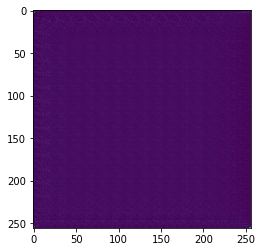

In [61]:
plt.imshow(output_img)